# Image color correction based on the reference sclera

Can be applied to MST images since the sclera is visible

Taken from "Colour balancing using sclera colour"

The average sclera value in CIE xyY colour space for x and y is 0.369 and 0.367, with a relative standard deviation of 2.41 and 2.43%.

1. Scele illuminant estimation: the ratio between computed pixel average colour of the sclera region c̄sclera and the reference average sclera colour under the canonical illuminant. Formula: I = c̄sclera/ρsclera. This sould output I = (Ix, Iy, Iz)

2. Chromatic adaptation: each pixel in
the image is colour corrected using the von Kries model

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import cv2
import mediapipe as mp

sys.path.append('../')
from utils import color_correction_utils
from utils import baseline_utils
from utils import sclera_segmentation_utils

sys.path.append('/home/dasec-notebook/Thesis/sclera-segmentation/src')
import sclera # NOTE: This is the custom module for sclera segmentation taken from https://github.com/wkabbani/sclera-segmentation

%load_ext autoreload
%autoreload 2

2025-01-16 21:59:56.586641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Otsu segmentation on a full image

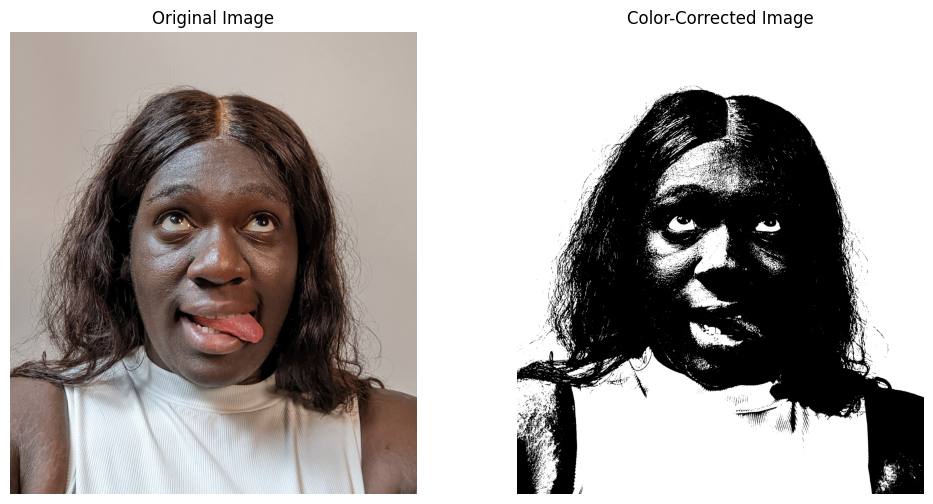

In [76]:
image = cv2.imread(
    "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_4/PXL_20220922_161932128.jpg"
)

# Perform Otsu's thresholding
thresholded_image = color_correction_utils.otsu_segmentation(image)

# plot original and thresholded images

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_BGR2RGB))
plt.title("Color-Corrected Image")
plt.axis("off")

plt.show()

# Sclera segmentation and mean sclera RGB extraction

1. Segments sclera based on landmark extraction
2. Adds additional Otsu segmentation
3. Calculates the color and exposure illuminants

I0000 00:00:1737062479.174526   15688 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737062479.179036   17310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1737062479.189650   17306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737062479.225510   17304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


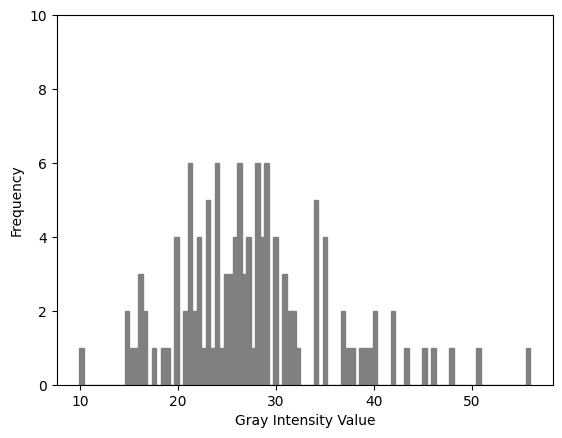

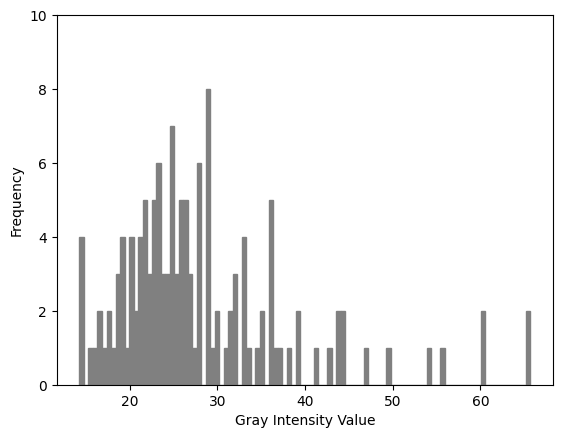

[47.91044776 20.75373134 15.08208955]
[46.77235772 20.43902439 14.74796748]


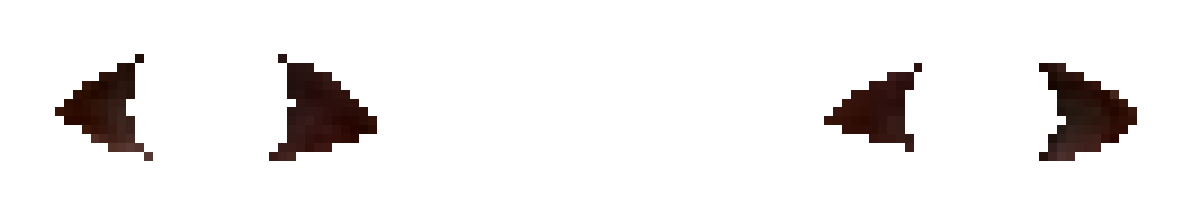

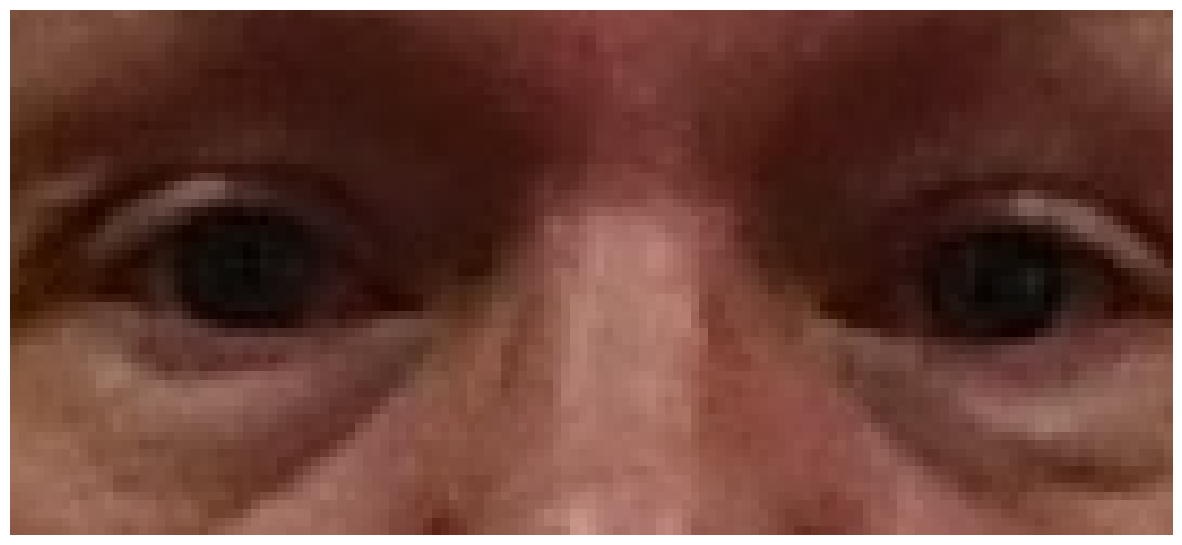

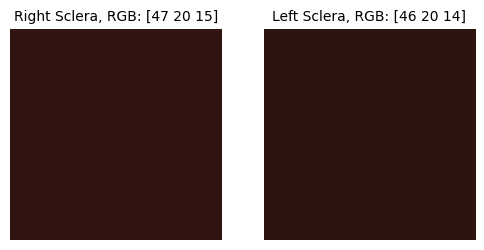

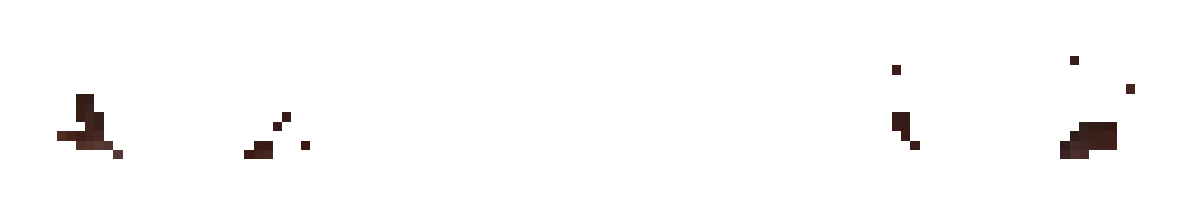

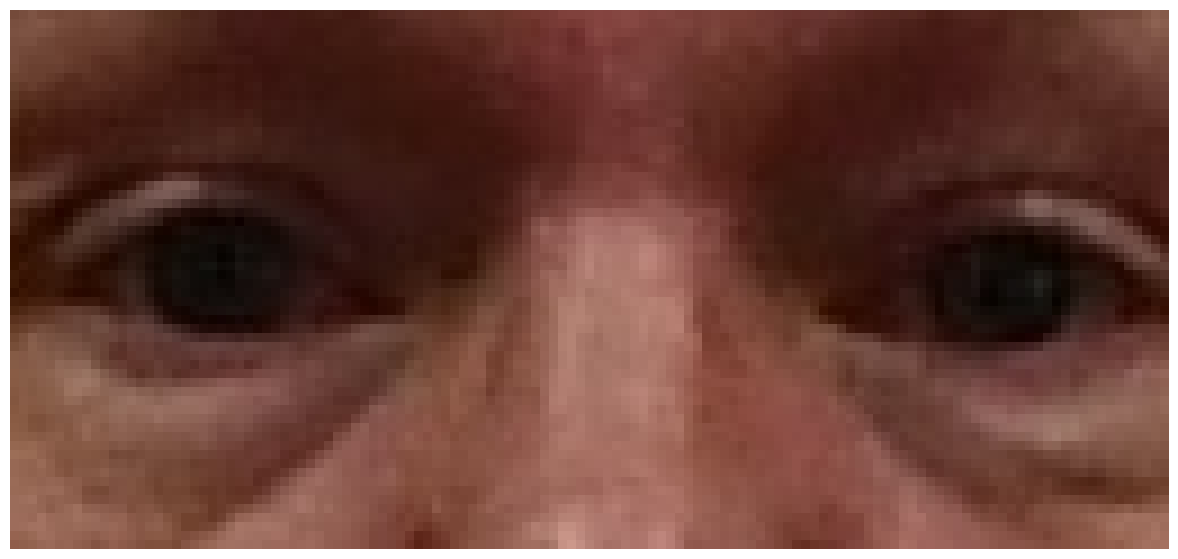

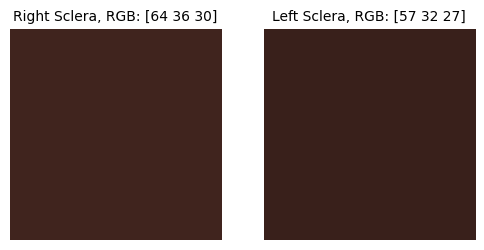

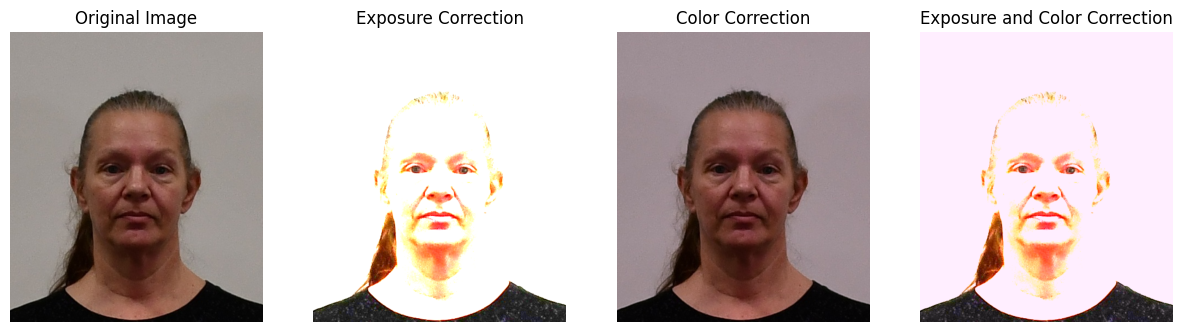

In [12]:
# Constants for the reference average sclera color in the CIE xyY color space
reference_sclera_xy = (0.369, 0.367)
reference_Y = 1
relative_std_dev = (2.41 / 100, 2.43 / 100)

# Load the image
# image_path = '/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00022/DSC_0291.JPG'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_140956208.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_9/PXL_20220922_140315071.PORTRAIT.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_140951373.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_141142245.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_4/PXL_20220922_161932128.jpg'


image_path = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00035/DSC_0300.JPG"

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found at the specified path!")

height, width, _ = image.shape

mp_face_mesh = mp.solutions.face_mesh
l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path)

# Extract sclera pixel values
if l_locations and r_locations:
    l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)

# Plot the gray scale histogram of the sclera regions
color_correction_utils.plot_gray_scale_histograms(
    l_values, "PXL_20220922_161932128 left sclera histogram"
)
color_correction_utils.plot_gray_scale_histograms(
    r_values, "PXL_20220922_161932128 right sclera histogram"
)


# Initial segmentation

mask = np.zeros(image.shape, dtype=bool)

for loc in l_locations + r_locations:
    x, y = loc
    mask[y, x] = True

masked_image = image.copy()
masked_image[~mask] = 255

masked_image = Image.fromarray(masked_image)
if isinstance(masked_image, Image.Image):
    masked_image = np.array(masked_image)

sclera_coords = np.column_stack(np.where(mask[..., 0]))

# Otsu segmentation

if l_locations and r_locations:

    l_eye_mask = color_correction_utils.create_eye_mask_otsu(
        l_locations, l_values, height, width
    )
    r_eye_mask = color_correction_utils.create_eye_mask_otsu(
        r_locations, r_values, height, width
    )

    otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)
    masked_otsu_image = cv2.bitwise_and(image, image, mask=otsu_mask)

    white_background_otsu_mask = np.ones_like(image, dtype=np.uint8) * 255
    masked_otsu_image_white_background = np.where(
        otsu_mask[..., None] == 255, masked_otsu_image, white_background_otsu_mask
    )

otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))


# Compute average RGB values for the sclera regions
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

l_avg_rgb = l_values.mean(axis=0)
r_avg_rgb = r_values.mean(axis=0)

l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
    image, l_eye_mask, patch_size=1
)
r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
    image, r_eye_mask, patch_size=1
)

# Plot the initial and final segmentation regions
color_correction_utils.plot_sclera(
    image,
    sclera_coords,
    masked_image,
    l_avg_rgb,
    r_avg_rgb,
    "Initial segmentation Region, mean RGB",
)
color_correction_utils.plot_sclera(
    image,
    otsu_sclera_coords,
    masked_otsu_image_white_background,
    l_otsu_moving_avg_rgb,
    r_otsu_moving_avg_rgb,
    "Moving Avg Cropped Otsu segmentation Region",
)


# Color correction based on sclera
# Convert average sclera color to xyY
l_xyY = color_correction_utils.rgb_to_xyY(l_otsu_moving_avg_rgb)
r_xyY = color_correction_utils.rgb_to_xyY(r_otsu_moving_avg_rgb)

# Compute the illuminant estimation for both sides (assuming symmetry)
I_x = (l_xyY[0] + r_xyY[0]) / 2
I_y = (l_xyY[1] + r_xyY[1]) / 2
I_Y = (l_xyY[2] + r_xyY[2]) / 2

# Normalize the reference sclera values (from canonical illuminant)
reference_x, reference_y = reference_sclera_xy
illuminant_ratio = (I_x / reference_x, I_y / reference_y)
exposure_factor = I_Y / reference_Y

image_corrected_exposure = color_correction_utils.adjust_exposure(
    image, exposure_factor
)

# Perform chromatic adaptation
corrected_image = color_correction_utils.von_kries_correction(image, illuminant_ratio)
corrected_exposure_color_image = color_correction_utils.von_kries_correction(
    image_corrected_exposure, illuminant_ratio
)

# Plot original and corrected images side by side
plt.figure(figsize=(15, 8))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(image_corrected_exposure)
plt.title("Exposure Correction")
plt.axis("off")

# Corrected Image
plt.subplot(1, 4, 3)
plt.imshow(corrected_image)
plt.title("Color Correction")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(corrected_exposure_color_image)
plt.title("Exposure and Color Correction")
plt.axis("off")


plt.show()

# Color correction on multiple images

Color and exposure correction based on sclera reference, saves images locally

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

# Reference average sclera color in the CIE xyY color space
reference_sclera_xy = (0.369, 0.367)  # xyY reference values
relative_std_dev = (2.41 / 100, 2.43 / 100)

# Root directory paths
input_root_dir = (
    "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2"
)
output_root_dir = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction"

color_correction_folder = "color_correction"
exposure_correction_folder = "exposure_correction"
exposure_color_correction_folder = "exposure_color_correction"

mp_face_mesh = mp.solutions.face_mesh

# Walk through the input directory tree
for root, dirs, files in os.walk(input_root_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            input_image_path = os.path.join(root, file)

            image = cv2.imread(input_image_path)

            if image is None:
                print(f"Warning: Could not read {input_image_path}. Skipping.")
                continue

            height, width, _ = image.shape

            # Get sclera locations
            l_locations, r_locations = sclera.get_sclera_location(
                mp_face_mesh, input_image_path
            )

            if not (l_locations and r_locations):
                print(
                    f"Warning: Sclera locations not found in {input_image_path}. Skipping."
                )
                continue

            l_locations = sclera_segmentation_utils.clip_coordinates(
                l_locations, height, width
            )
            r_locations = sclera_segmentation_utils.clip_coordinates(
                r_locations, height, width
            )

            # Extract sclera pixel values
            l_values, r_values = sclera.get_sclera_pixels(
                input_image_path, l_locations, r_locations
            )

            # Perform Otsu segmentation
            l_eye_mask = color_correction_utils.create_eye_mask_otsu(
                l_locations, l_values, height, width
            )
            r_eye_mask = color_correction_utils.create_eye_mask_otsu(
                r_locations, r_values, height, width
            )
            otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)

            otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))

            # Convert to RGB for processing
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
                image, l_eye_mask, patch_size=5
            )
            r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
                image, r_eye_mask, patch_size=5
            )

            l_otsu_moving_avg_rgb = [
                int(round(value)) for value in l_otsu_moving_avg_rgb
            ]
            r_otsu_moving_avg_rgb = [
                int(round(value)) for value in r_otsu_moving_avg_rgb
            ]

            # Proceed if at least one average is valid
            if l_otsu_moving_avg_rgb is not None or r_otsu_moving_avg_rgb is not None:
                # Default to the available values for calculations
                if l_otsu_moving_avg_rgb is None:
                    l_otsu_moving_avg_rgb = r_otsu_moving_avg_rgb
                    print(
                        f"Warning: Left eye average not found in {input_image_path}. Using right eye average instead."
                    )
                if r_otsu_moving_avg_rgb is None:
                    r_otsu_moving_avg_rgb = l_otsu_moving_avg_rgb
                    print(
                        f"Warning: Right eye average not found in {input_image_path}. Using left eye average instead."
                    )

                # Color correction based on sclera
                l_xyY = color_correction_utils.rgb_to_xyY(l_otsu_moving_avg_rgb)
                r_xyY = color_correction_utils.rgb_to_xyY(r_otsu_moving_avg_rgb)

                # Compute illuminant estimation
                I_x = (l_xyY[0] + r_xyY[0]) / 2
                I_y = (l_xyY[1] + r_xyY[1]) / 2
                I_Y = (l_xyY[2] + r_xyY[2]) / 2

                # Normalize reference values
                reference_x, reference_y = reference_sclera_xy
                illuminant_ratio = (I_x / reference_x, I_y / reference_y)
                exposure_factor = reference_sclera_xy[1] / I_Y

                # Correct exposure
                image_corrected_exposure = color_correction_utils.adjust_exposure(
                    image, exposure_factor
                )

                # Perform chromatic adaptation
                corrected_image = color_correction_utils.von_kries_correction(
                    image, illuminant_ratio
                )
                corrected_exposure_color_image = (
                    color_correction_utils.von_kries_correction(
                        image_corrected_exposure, illuminant_ratio
                    )
                )

                # Save output images
                folder_name = os.path.basename(root)

                if not os.path.exists(
                    os.path.join(output_root_dir, color_correction_folder, folder_name)
                ):
                    os.makedirs(
                        os.path.join(
                            output_root_dir, color_correction_folder, folder_name
                        )
                    )

                if not os.path.exists(
                    os.path.join(
                        output_root_dir, exposure_correction_folder, folder_name
                    )
                ):
                    os.makedirs(
                        os.path.join(
                            output_root_dir, exposure_correction_folder, folder_name
                        )
                    )

                if not os.path.exists(
                    os.path.join(
                        output_root_dir, exposure_color_correction_folder, folder_name
                    )
                ):
                    os.makedirs(
                        os.path.join(
                            output_root_dir,
                            exposure_color_correction_folder,
                            folder_name,
                        )
                    )

                cv2.imwrite(
                    os.path.join(
                        output_root_dir, color_correction_folder, folder_name, file
                    ),
                    cv2.cvtColor(corrected_image, cv2.COLOR_RGB2BGR),
                )
                cv2.imwrite(
                    os.path.join(
                        output_root_dir, exposure_correction_folder, folder_name, file
                    ),
                    cv2.cvtColor(image_corrected_exposure, cv2.COLOR_RGB2BGR),
                )
                cv2.imwrite(
                    os.path.join(
                        output_root_dir,
                        exposure_color_correction_folder,
                        folder_name,
                        file,
                    ),
                    cv2.cvtColor(corrected_exposure_color_image, cv2.COLOR_RGB2BGR),
                )

                print(f"Processed and saved: {input_image_path}")

            else:
                print(
                    f"Warning: Average sclera color not found in {input_image_path}. Skipping."
                )